# Test 20: Fisher’s cumulant test for normality of a population

## Objective

- You have a sample of values
- I compute the sample mean and variance
- How confident am I that this sample came from a population with the same mean and variance?

## Assumptions

- The sample size should be large, say n > 50. 
- The two distributions MUST have the same mean and variance, use `Test 33: W/S Test` instead

## Method

- Let's begin by defining what it means to have sample moments

- The $r$-th moment about the mean is defined below, where
    - $f(x_i)$ is the probability mass function or probability density function of the distribution
    - $\bar{x}$ is the mean of the distribution. Moments are computed relative to the mean value by default, though that can differ
    - Note that scipy's default computes the moments relative to the mean
    - Note also that the zero-th moment is always 1 by definition (because you are just summing across the PMF/PDF)
$$\begin{aligned}
    M_r &= \sum_{i=1}^{n} (x_i - \bar{x})^r \cdot f(x_i)
\end{aligned}$$

- Next, we can use the moments to compute Fisher's $K$-Statistics
$$\begin{aligned}
    K_1 &= \frac{M_1}{n} \\
    K_2 &= \frac{n M_2 - M_1^2}{n(n-1)} \\
    K_3 &= \frac{n^2 M_3 - 3n M_2 M_1 + 2 M_1^3}{n (n-1) (n-2)} \\
    K_4 &= \frac{(n^3 + n^2) M_4 - 4 (n^2 + 2) M_3 M_1 - 3 (n^2 - n)M_2^2 + 12 M_2 M_1^2 - 6M_1^4}{n (n-1) (n-2) (n-3)} \\
\end{aligned}$$

- Finally, we can compute the following test statistics, where we test for skewness and kurtosis separately, or together

- Test for skewness; test statistic follows Gaussian distribution
$$\begin{aligned}
    u_1 &= \frac{K_3}{K_2^{\frac{3}{2}}} \cdot (\frac{n}{6})^{0.5}
\end{aligned}$$
    
- Test for kurtosis; test statistic follows Gaussian distribution
$$\begin{aligned}
    u_2 &= \frac{K_4}{K_2^2} \cdot (\frac{n}{24})^{0.5}
\end{aligned}$$
    
- Combined test; test statistic follows a $\chi^2$ distribution with 2 degrees of freedom
$$\begin{aligned}
    \chi^2 &= [\frac{K_3}{(K_2)^{\frac{3}{2}}} \cdot (\frac{n}{6})^{0.5}]^2 + [\frac{K_4}{(K_2)^2} \cdot (\frac{n}{24})^{0.5}]^2
\end{aligned}$$

In [74]:
import numpy as np
import scipy

arr1 = np.random.normal(0,1,5)
moment=2

print(
    np.sum(
        (arr1 - np.mean(arr1))**moment * 1/len(arr1)
    )
)
print(scipy.stats.moment(arr1, moment=moment))

0.4220081027486921
0.42200810274869205


## Proofs by simulation

### Proof that the test statistics are normal/$\chi^2$

In [75]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
def compute_moments(array, moment):
    moment = (
        np.sum(
            (array - np.mean(array))**moment #* 1/len(array)
        )
    )
    return moment

def compute_fisher_k_stats(array):
    m1 = compute_moments(array, 1)
    m2 = compute_moments(array, 2)
    m3 = compute_moments(array, 3)
    m4 = compute_moments(array, 4)
    n = len(array)
    
    k1 = m1/n
    k2 = (n * m2 - m1**2)/(n * (n-1))
    k3 = (n**2 * m3 - 3*n*m2*m1 + 2*m1**3)/(n * (n-1) * (n-2))
    k4 = ((n**3 + n**2)*m4 - 4*(n**2+n)*m3*m1 - 3*(n**2-n)*m2**2 + 12*m2*m1**2 - 6*m1**4) / (n * (n-1) * (n-2) * (n-3))
    
    return k1, k2, k3, k4

def compute_test_statistics(array):
    k1, k2, k3, k4 = compute_fisher_k_stats(array)
    n = len(array)
    u1 = k3/k2**1.5 * (n/6)**0.5
    u2 = k4/k2**2 * (n/24)**0.5
    chisq = u1**2 + u2**2
    return u1, u2, chisq

def get_test_statistic_of_normal_dist():
    x = np.random.normal(0,1,3_000)
    u1, u2, chisq = compute_test_statistics(x)
    return u1, u2, chisq

def get_test_statistic_of_shifted_normal_dist():
    x = np.random.normal(5,3,3_000)
    u1, u2, chisq = compute_test_statistics(x)
    return u1, u2, chisq

In [104]:
u1_test_statistic_distribution = np.array([get_test_statistic_of_normal_dist()[0] for _ in range(3_000)])
u2_test_statistic_distribution = np.array([get_test_statistic_of_normal_dist()[1] for _ in range(3_000)])
chisq_test_statistic_distribution = np.array([get_test_statistic_of_normal_dist()[2] for _ in range(3_000)])
true_normal_distribution = np.random.normal(0,1,3_000)
true_chisq_distribution = np.random.chisquare(2, 3_000)

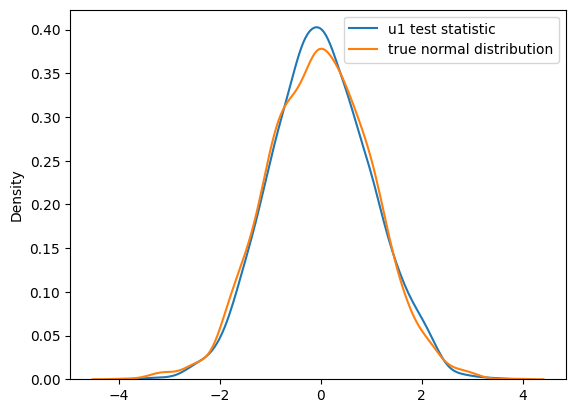

In [105]:
sns.kdeplot(u1_test_statistic_distribution, label='u1 test statistic')
sns.kdeplot(true_normal_distribution, label='true normal distribution')
plt.legend()

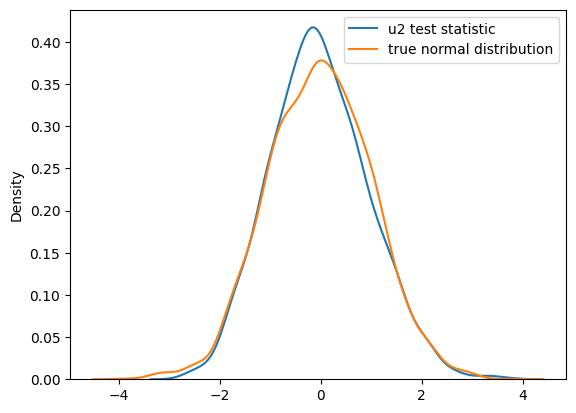

In [106]:
sns.kdeplot(u2_test_statistic_distribution, label='u2 test statistic')
sns.kdeplot(true_normal_distribution, label='true normal distribution')
plt.legend()

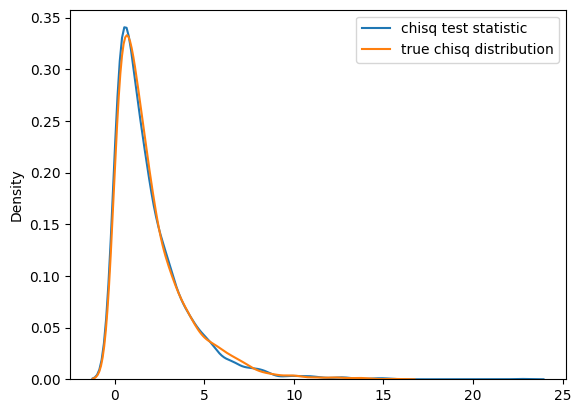

In [107]:
sns.kdeplot(chisq_test_statistic_distribution, label='chisq test statistic')
sns.kdeplot(true_chisq_distribution, label='true chisq distribution')
plt.legend()

### Proof that test statistic distinguishes between a frequency distribution from normal vs non-normal 

In [113]:
def get_test_statistic_of_non_normal_dist():
    x = np.random.exponential(scale=1, size=3_000)
    u1, u2, chisq = compute_test_statistics(x)
    return u1, u2, chisq

In [114]:
u1_test_statistic_distribution = np.array([get_test_statistic_of_non_normal_dist()[0] for _ in range(3_000)])
u2_test_statistic_distribution = np.array([get_test_statistic_of_non_normal_dist()[1] for _ in range(3_000)])
chisq_test_statistic_distribution = np.array([get_test_statistic_of_non_normal_dist()[2] for _ in range(3_000)])
true_normal_distribution = np.random.normal(0,1,3_000)
true_chisq_distribution = np.random.chisquare(2, 3_000)

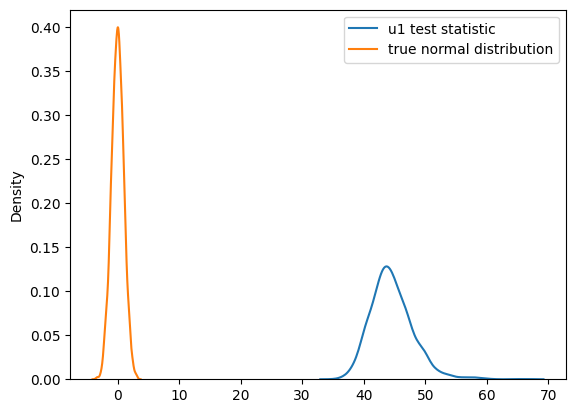

In [115]:
sns.kdeplot(u1_test_statistic_distribution, label='u1 test statistic')
sns.kdeplot(true_normal_distribution, label='true normal distribution')
plt.legend()

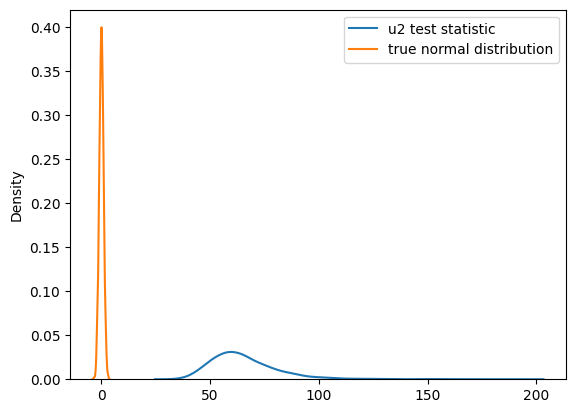

In [116]:
sns.kdeplot(u2_test_statistic_distribution, label='u2 test statistic')
sns.kdeplot(true_normal_distribution, label='true normal distribution')
plt.legend()

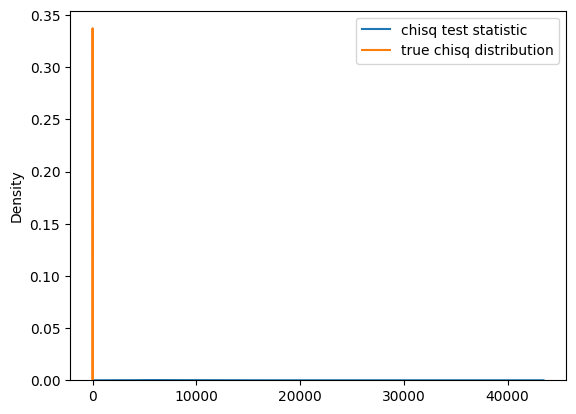

In [117]:
sns.kdeplot(chisq_test_statistic_distribution, label='chisq test statistic')
sns.kdeplot(true_chisq_distribution, label='true chisq distribution')
plt.legend()